In [1]:
import librosa
import librosa.display
from playsound import playsound

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Partie 1 : Manipulation de fichiers audio

### Partie 1.1

In [2]:
audio_file = 'audio/classique/Mozart-String-Quartet.mp3'

# Décommenter pour lancer l'audio
# playsound(audio_file)

### Partie 1.2

In [4]:
y, sr = librosa.load(audio_file, sr=None)

print(f"Fréquence d'échantillonnage : {sr} Hz")
print(f"Nombre de valeurs dans l'audio : {len(y)}")

duration = len(y) / sr
print(f"Durée du morceau : {duration:.4f} secondes")

Fréquence d'échantillonnage : 44100 Hz
Nombre de valeurs dans l'audio : 11819689
Durée du morceau : 268.0202 secondes


### Partie 1.3

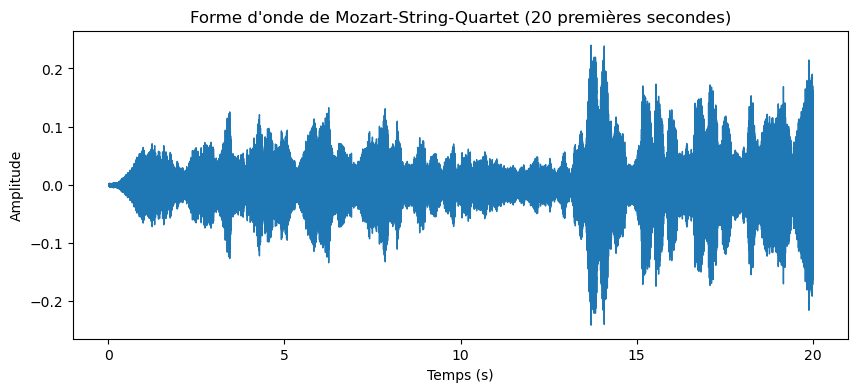

In [6]:
y_20s = y[:int(sr * 20)]

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_20s, sr=sr)
plt.title(r"Forme d'onde de Mozart-String-Quartet (20 premières secondes)")
plt.xlabel(r'Temps (s)')
plt.ylabel(r'Amplitude')
plt.show()

# Partie 2 : Représentation MFCCs

### Partie 2.1 + 2.2

In [9]:
y_10s = y[:int(sr * 10)]
mfccs = librosa.feature.mfcc(y=y_10s, sr=sr, n_mfcc=12)

print(f"Dimensions des coefficients MFCCs : {mfccs.shape}")

frame_length = librosa.frames_to_time(mfccs.shape[-1], sr=sr)
print(f"Nombre de valeurs calculées par seconde : {int(mfccs.shape[-1] / frame_length)}")

Dimensions des coefficients MFCCs : (12, 862)
Nombre de valeurs calculées par seconde : 86


### Partie 2.3

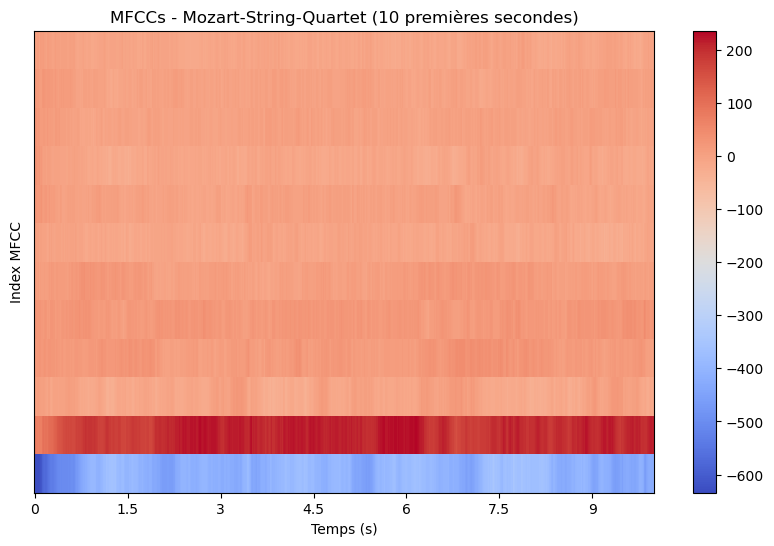

In [ ]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.title(r'MFCCs - Mozart-String-Quartet (10 premières secondes)')
plt.colorbar()
plt.xlabel(r'Temps (s)')
plt.ylabel(r'Index MFCC')
plt.show()

# Partie 3 : Préparation des descripteurs

### Partie 3.1

La fonction librosa.feature.mfcc retourne une matrice de dimensions (n_mfcc, n_frames) :

* n_mfcc : nombre de coefficients MFCC calculés par frame, $12$ dans ce cas.

* n_frames : nombre de fenêtres temporelles (frames), chaque fenêtre représentant une portion de l'audio.

La fonction mfcc renvoie donc une matrice où chaque colonne correspond à un descripteur temporel et chaque ligne correspond à un des 12 coefficients. Ce format est correct pour l'apprentissage, car chaque colonne (frame) représente une fenêtre temporelle de l'audio avec ses $12$ descripteurs.

### Partie 3.2

In [13]:
y, sr = librosa.load(audio_file, sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12).T

print(f"Forme des MFCCs avant normalisation : {mfccs.shape}")

scaler = StandardScaler()
mfccs_normalized = scaler.fit_transform(mfccs)

print(f"Forme des MFCCs après normalisation : {mfccs_normalized.shape}")

Forme des MFCCs avant normalisation : (23086, 12)
Forme des MFCCs après normalisation : (23086, 12)


### Partie 3.3

Moyennes après normalisation : [-5.2876339e-09 -1.5862902e-08  1.3219085e-09 -1.0575268e-08
  5.2876339e-09 -2.6438169e-09  0.0000000e+00  5.2876339e-09
 -5.2876339e-09  5.2876339e-09 -2.1150536e-08  2.6438169e-09]
Écarts-types après normalisation : [1.         1.         0.99999994 1.         1.         1.
 1.         1.         1.         0.99999994 1.         1.        ]


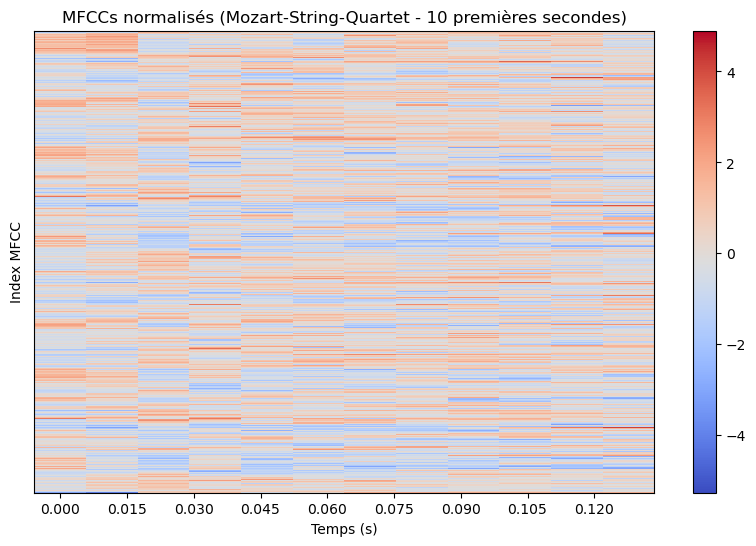

In [14]:
means = np.mean(mfccs_normalized, axis=0)
std_devs = np.std(mfccs_normalized, axis=0)

print("Moyennes après normalisation :", means)
print("Écarts-types après normalisation :", std_devs)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs_normalized, x_axis='time', sr=sr)
plt.title('MFCCs normalisés (Mozart-String-Quartet - 10 premières secondes)')
plt.colorbar()
plt.xlabel('Temps (s)')
plt.ylabel('Index MFCC')
plt.show()

# Partie 4 : Entraînement d'un modèle

### Partie 4.1

In [16]:
def extract_mfcc(audio_file, duration=20, sr=None):
    y, sr = librosa.load(audio_file, sr=sr, duration=duration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12).T
    scaler = StandardScaler()
    mfccs_normalized = scaler.fit_transform(mfccs)
    return mfccs_normalized

In [17]:
mozart_file = 'audio/classique/Mozart-String-Quartet.mp3'
rodrigo_file = 'audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3'

mozart_mfcc = extract_mfcc(mozart_file)
rodrigo_mfcc = extract_mfcc(rodrigo_file)

### Partie 4.2

In [18]:
mozart_labels = np.zeros(mozart_mfcc.shape[0])
rodrigo_labels = np.ones(rodrigo_mfcc.shape[0])

X = np.vstack((mozart_mfcc, rodrigo_mfcc))
y = np.hstack((mozart_labels, rodrigo_labels))

### Partie 4.3

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy * 100:.4f}%")

Précision du modèle : 95.7971%


# Partie 5 : Evaluation du modèle

### Partie 5.1

In [23]:
def extract_mfcc_validation(audio_file, start_sec=20, duration=5, sr=None):
    y, sr = librosa.load(audio_file, sr=sr, offset=start_sec, duration=duration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12).T
    scaler = StandardScaler()
    mfccs_normalized = scaler.fit_transform(mfccs)
    return mfccs_normalized

In [24]:
mozart_mfcc_validation = extract_mfcc_validation(mozart_file, start_sec=20)
rodrigo_mfcc_validation = extract_mfcc_validation(rodrigo_file, start_sec=20)

mozart_labels_validation = np.zeros(mozart_mfcc_validation.shape[0])
rodrigo_labels_validation = np.ones(rodrigo_mfcc_validation.shape[0])

X_validation = np.vstack((mozart_mfcc_validation, rodrigo_mfcc_validation))
y_validation = np.hstack((mozart_labels_validation, rodrigo_labels_validation))

### Partie 5.2

In [25]:
y_pred_validation = svm_model.predict(X_validation)

### Partie 5.3

In [27]:
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Précision sur l'ensemble de validation : {accuracy_validation * 100:.4f}%")

Précision sur l'ensemble de validation : 78.7703%


### Partie 5.4

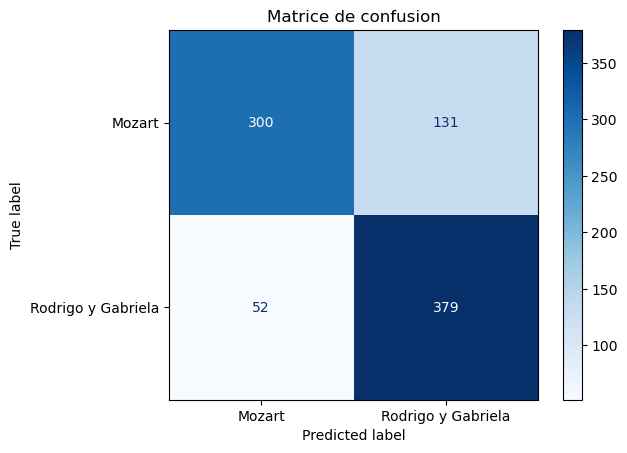

In [28]:
cm = confusion_matrix(y_validation, y_pred_validation, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mozart", "Rodrigo y Gabriela"])
disp.plot(cmap='Blues')

plt.title('Matrice de confusion')
plt.show()

# Partie 6 : Expériences

In [43]:
def extract_mfccs(track1_audio_path, track2_audio_path, duration=20, start=0, n_mfcc=12, n_fft=2048, sr=None):
    # Track 1
    y1, sr1 = librosa.load(track1_audio_path, sr=sr)
    y1 = y1[start * sr1:(start + duration) * sr1]
    mfccs_track1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=n_mfcc, n_fft=n_fft).T
    scaler_track1 = StandardScaler()
    mfccs_normalized_track1 = scaler_track1.fit_transform(mfccs_track1)
    labels1 = np.zeros(mfccs_normalized_track1.shape[0])

    # Track 2
    y2, sr2 = librosa.load(track2_audio_path, sr=None)
    y2 = y2[start * sr2:(start + duration) * sr2]
    mfccs_track2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=n_mfcc, n_fft=n_fft).T
    scaler_track2 = StandardScaler()
    mfccs_normalized_track2 = scaler_track2.fit_transform(mfccs_track2)
    labels2 = np.ones(mfccs_normalized_track2.shape[0])

    X_train = np.vstack((mfccs_normalized_track1, mfccs_normalized_track2))
    y_train = np.hstack((labels1, labels2))

    return X_train, y_train

### Partie 6.1

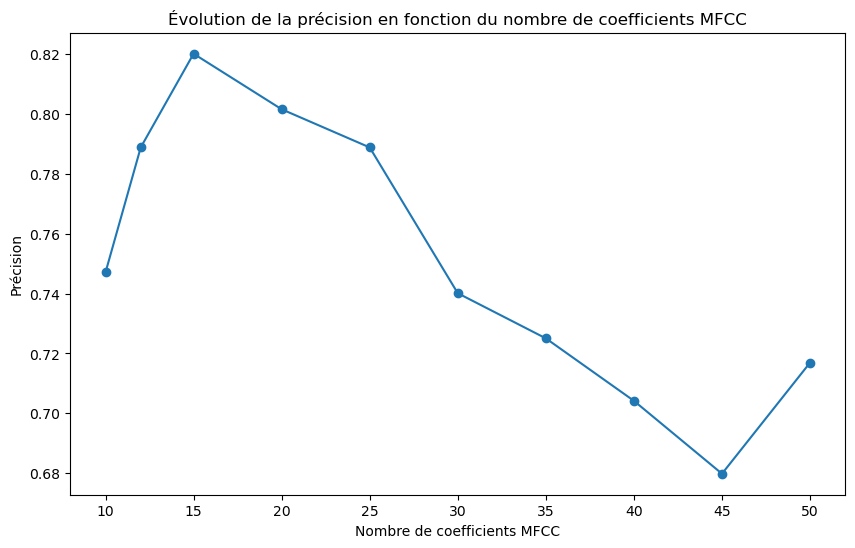

In [45]:
n_mfcc_values = [10, 12, 15, 20, 25, 30, 35, 40, 45, 50]
accuracies = []

for n_mfcc in n_mfcc_values:
    X_train, y_train = extract_mfccs(mozart_file, rodrigo_file, duration=20, n_mfcc=n_mfcc)
    classifier = SVC(kernel='rbf', random_state=42)
    classifier.fit(X_train, y_train)

    X_val, y_val = extract_mfccs(mozart_file, rodrigo_file, duration=5, start=20, n_mfcc=n_mfcc)
    y_pred = classifier.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(n_mfcc_values, accuracies, marker='o')
plt.xlabel(r'Nombre de coefficients MFCC')
plt.ylabel(r'Précision')
plt.title(r'Évolution de la précision en fonction du nombre de coefficients MFCC')
plt.show()

### Partie 6.2

c:\Users\Romain Bonhomme\Miniconda\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\Romain Bonhomme\Miniconda\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\Romain Bonhomme\Miniconda\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\Romain Bonhomme\Miniconda\lib\site-packages\librosa\fea

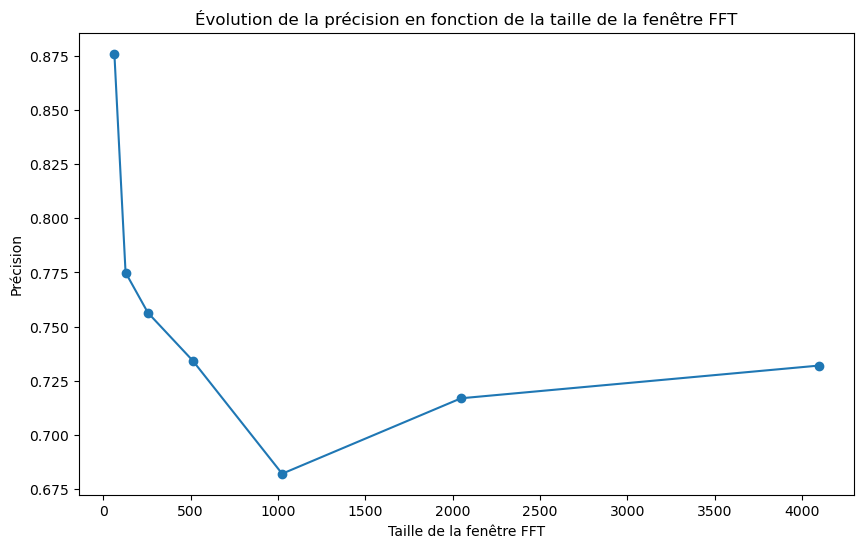

In [47]:
window_sizes = [64, 128, 256, 512, 1024, 2048, 4096]
accuracies = []

for win_size in window_sizes:
    X_train, y_train = extract_mfccs(mozart_file, rodrigo_file, duration=20, n_mfcc=n_mfcc, n_fft=win_size)
    classifier = SVC(kernel='rbf', random_state=42)
    classifier.fit(X_train, y_train)

    X_val, y_val = extract_mfccs(mozart_file, rodrigo_file, duration=5, start=20, n_mfcc=n_mfcc, n_fft=win_size)
    y_pred = classifier.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.xlabel('Taille de la fenêtre FFT')
plt.ylabel('Précision')
plt.title('Évolution de la précision en fonction de la taille de la fenêtre FFT')
plt.show()

### Partie 6.3

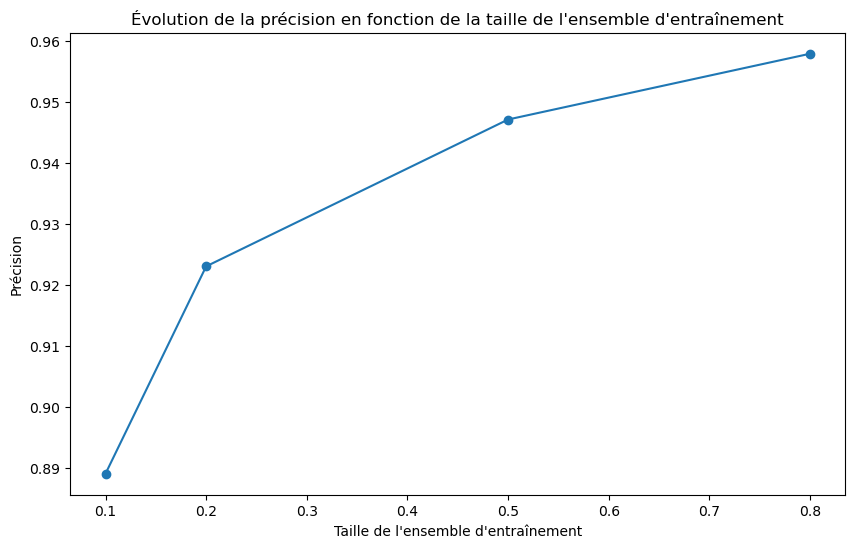

In [48]:
def experiment_training_set_size(audio_file, training_sizes):
    scores = []
    
    for train_size in training_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

        svm_model.fit(X_train, y_train)

        y_pred = svm_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes, scores, marker='o')
    plt.xlabel(r"Taille de l'ensemble d'entraînement")
    plt.ylabel(r'Précision')
    plt.title(r"Évolution de la précision en fonction de la taille de l'ensemble d'entraînement")
    plt.show()

training_sizes = [0.1, 0.2, 0.5, 0.8]
experiment_training_set_size(mozart_file, training_sizes)

### Partie 6.5

In [55]:
track1_train = 'audio/classique/Mozart-String-Quartet.mp3'
track2_train = 'audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3'

track1_val = 'audio/classique/Haydn-String-Quartet.mp3'
track2_val = 'audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3'

X_train, y_train = extract_mfccs(track1_train, track2_train, duration=20, n_mfcc=12)
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(X_train, y_train)
X_val, y_val = extract_mfccs(track1_val, track2_val, duration=5, start=20, n_mfcc=12)
y_pred = classifier.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print(f"Précision du classifieur : {acc * 100:.4f}%")

Précision du classifieur : 67.5174%


### Partie 6.6

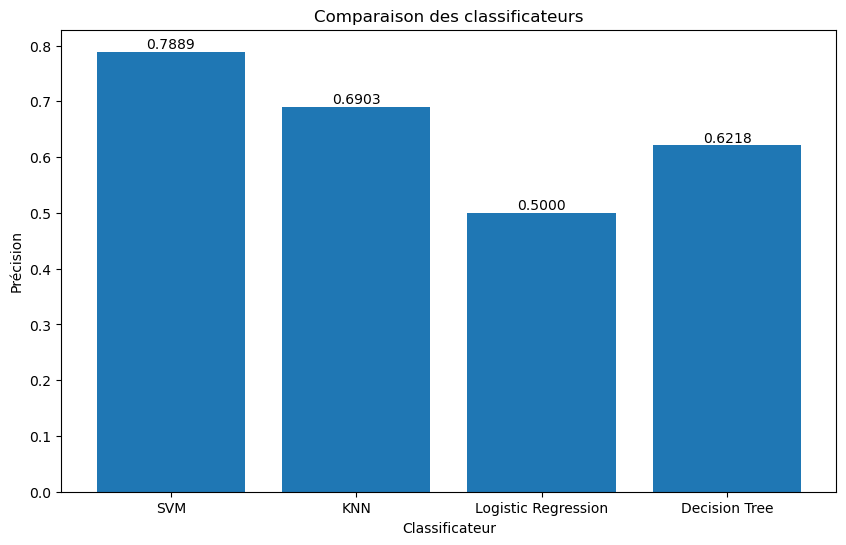

In [60]:
def experiment_classifiers(X_train, y_train, X_test, y_test):
    classifiers = {
        "SVM": SVC(kernel='rbf'),
        "KNN": KNeighborsClassifier(),
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier()
    }
    
    scores = {}
    
    for name, clf in classifiers.items():
        X_train, y_train = extract_mfccs(mozart_file, rodrigo_file, duration=20, n_mfcc=12)
        clf.fit(X_train, y_train)
        X_val, y_val = extract_mfccs(mozart_file, rodrigo_file, duration=5, start=20, n_mfcc=12)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        scores[name] = acc

    plt.figure(figsize=(10, 6))
    bars = plt.bar(scores.keys(), scores.values())
    plt.xlabel(r'Classificateur')
    plt.ylabel(r'Précision')
    plt.title(r'Comparaison des classificateurs')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', 
                 ha='center', va='bottom', fontsize=10)

    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
experiment_classifiers(X_train, y_train, X_test, y_test)